In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from semantic_discriminator_trainer import train
from deformation.semantic_discriminator_dataset import SemanticDiscriminatorDataset
from deformation.semantic_discriminator_net import SemanticDiscriminatorNetwork
from adversarial.datasets import GenerationDataset, ShapenetRendersDataset


In [4]:
def get_exp_path(exp_name):
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:]:
                exp_path.append(d)
    if len(exp_path) > 1:
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [5]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:52: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


In [47]:


#exp_name = "2020_08_30--06_30_46_b10_original"
#exp_name = "2020_08_30--06_32_06_b10_extended_pointnet"
#exp_name = "2020_08_30--07_00_47_b10_extended_pointnet_resnet34"
#n = "2020_08_30--21_39_02_b5_original"
#n = "2020_08_30--21_46_39_b1_original"
#n = "2020_08_30--21_53_06_b20_size_8"
#n = "2020_08_30--21_54_28_b40_size_4"
#n = "2020_08_30--22_00_02_lr_larger"

#n="2020_08_31--10_31_12_b10_lr001"

#n="2020_08_31--10_26_04_b20_new"
#n="2020_08_31--10_27_20_b30_new"
#n="2020_08_31--10_28_11_b40_new"
n="2020_08_31--10_32_41_bfull_new"


saved_model_path = "out/{}".format(get_exp_path(n))

print(saved_model_path)

/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:52: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg_special = yaml.load(f)
/home/svcl-oowl/brandon/research/sil_consistent_at_inference/utils/utils.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


out/2020_08_31--10_32_41_bfull_new


# Show Adversarial Training Info

,batch,img_sym_loss,iteration,l2_loss,lap_smoothness_loss,lr,normal_consistency_loss,semantic_dis_loss,sil_loss,total_loss,vertex_sym_loss
0,0.0,0.011136,0.0,0.000961,0.053311,0.0001,1.086591,0.0,13.077504,278.845123,53.392262
1,1.0,0.008624,0.0,0.000448,0.037665,0.0001,0.923906,0.0,11.682699,248.776123,50.752151
2,2.0,0.006691,0.0,0.000285,0.030915,0.0001,0.844763,0.0,8.894686,191.697586,47.125149
3,3.0,0.006776,0.0,0.000252,0.029140,0.0001,0.843886,0.0,10.626808,226.300751,46.955254
4,4.0,0.006280,0.0,0.000220,0.027489,0.0001,0.773156,0.0,8.223978,177.464020,46.640511
...,...,...,...,...,...,...,...,...,...,...,...
22420,70.0,0.005810,298.0,0.003364,0.013446,0.0001,0.140937,0.0,2.915493,62.723495,25.793079
22421,71.0,0.005677,298.0,0.002455,0.014962,0.0001,0.136608,0.0,2.185375,48.397766,28.906975
22422,72.0,0.005923,298.0,0.003580,0.014553,0.0001,0.137606,0.0,2.812518,60.655708,25.876167
22423,73.0,0.005784,298.0,0.002432,0.013508,0.0001,0.138745,0.0,3.641060,77.475861,28.429340


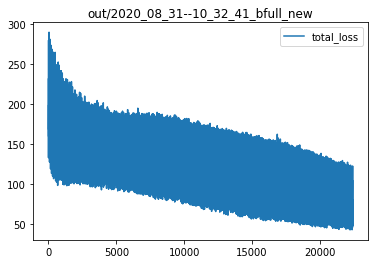

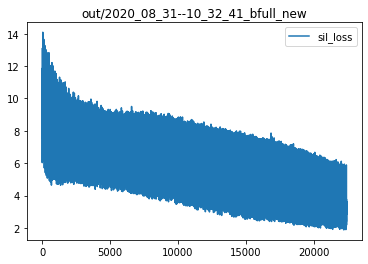

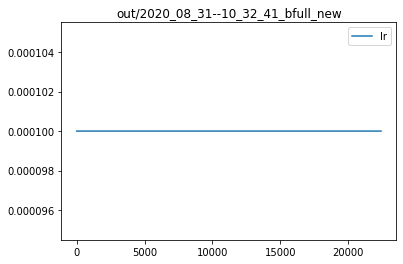

In [48]:
# show training info
training_info = pickle.load(open(os.path.join(saved_model_path, "training_df.p"), "rb"))
semantic_dis_training_df = training_info["semantic_dis"]
deform_gen_training_df = training_info["deform_net_gen"]
deform_gen_training_df["lr"] = deform_gen_training_df["lr"].astype(str).apply(lambda s: float(s.replace("[", "").replace(']','')))
display(deform_gen_training_df)
deform_gen_training_df.plot.line(y="total_loss", title=saved_model_path)

#deform_gen_training_df.plot.line(y="semantic_dis_loss", title=saved_model_path)
deform_gen_training_df.plot.line(y="sil_loss", title=saved_model_path)
deform_gen_training_df.plot.line(y="lr", title=saved_model_path)

#deform_gen_training_df.plot.line(y="img_sym_loss", title=saved_model_path)
#deform_gen_training_df.plot.line(y="vertex_sym_loss", title=saved_model_path)

#deform_gen_training_df.plot.line(y="l2_loss", title=saved_model_path)
#deform_gen_training_df.plot.line(y="lap_smoothness_loss", title=saved_model_path)
#deform_gen_training_df.plot.line(y="normal_consistency_loss", title=saved_model_path)

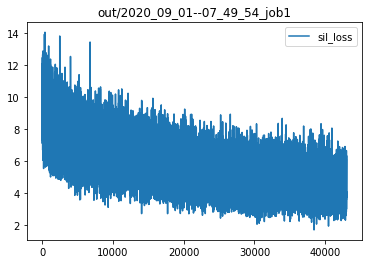

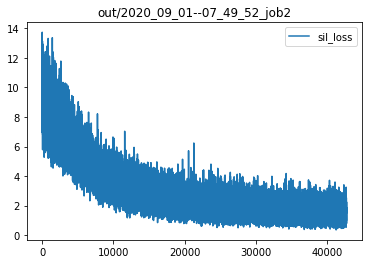

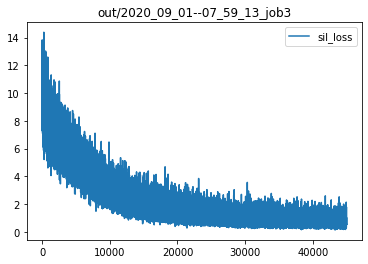

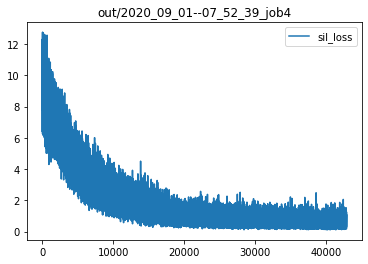

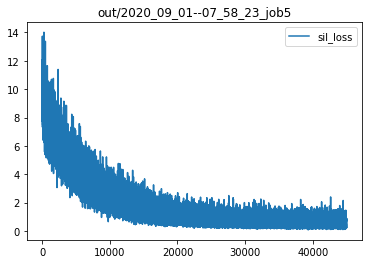

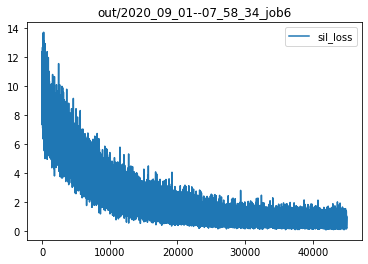

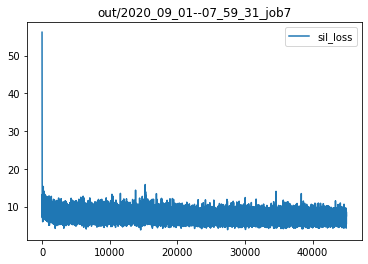

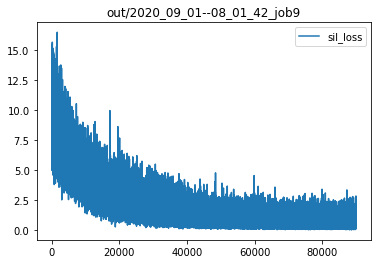

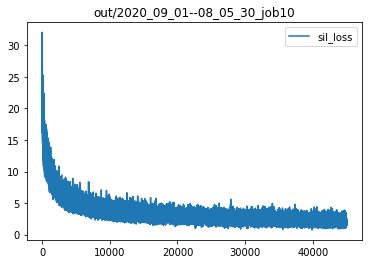

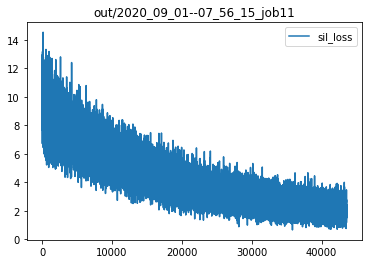

In [6]:
paths = []
for i in range(11):
    if i not in [5,7]:
        saved_model_path = "out/{}".format(get_exp_path("job{}".format(i+1)))
        paths.append(saved_model_path)
paths.insert(5, "out/2020_09_01--07_58_34_job6")
for p in paths:
    training_info = pickle.load(open(os.path.join(p, "training_df.p"), "rb"))
    semantic_dis_training_df = training_info["semantic_dis"]
    deform_gen_training_df = training_info["deform_net_gen"]
    #deform_gen_training_df.plot.line(y="total_loss", title=p)
    deform_gen_training_df.plot.line(y="sil_loss", title=p)

# Show Adversarial Training Results

In [28]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path):
    input_dir_img = cfg['dataset']['input_dir_img']
    input_dir_mesh = cfg['dataset']['input_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["input_dir_pose"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    print(processed_paths)
    processed_paths_dict = {str(path).split('/')[-1][:-4]:str(path) for path in processed_paths}
   
    for instance_name in processed_paths_dict:
        input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
        with torch.no_grad():
            mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
            mesh_processed = utils.load_untextured_mesh(processed_paths_dict[instance_name], device)

        # rendering original and processed mesh at predicted pose
        pred_dist = cached_pred_poses[instance_name]['dist']
        pred_elev = cached_pred_poses[instance_name]['elev']
        pred_azim = cached_pred_poses[instance_name]['azim']
        R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
        mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
        mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)

        # visualizing
        print(instance_name)
        fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
        ax[0][0].imshow(input_image)
        ax[0][0].xaxis.set_visible(False)
        ax[0][0].yaxis.set_visible(False)

        ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
        ax[0][1].xaxis.set_visible(False)
        ax[0][1].yaxis.set_visible(False)

        ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
        ax[0][2].xaxis.set_visible(False)
        ax[0][2].yaxis.set_visible(False)
        plt.pause(0.05)

In [29]:
#show_meshes(cfg, device, saved_model_path)
show_meshes(cfg, device, "out/2020_09_01--07_58_34_job6")


[]
